<a href="https://colab.research.google.com/github/thanaphornkanking/Project/blob/main/%E0%B9%80%E0%B8%97%E0%B8%A3%E0%B8%99%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5%E0%B8%95%E0%B9%88%E0%B8%AD%E0%B8%94%E0%B9%89%E0%B8%A7%E0%B8%A2_id14(200).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  # คลิกที่ลิงก์ -> เลือก E-mail -> ลงชื่อเข้าใช้ -> ก็อปโค้ด -> นำกลับมาวางในช่องว่าง -> กด enter

Mounted at /content/drive


In [2]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [3]:
batch_size = 20
width = 150
height = 150
epochs = 100
NUM_TRAIN = 100
NUM_TEST = 100
dropout_rate = 0.2
input_shape = (height, width, 3)

In [4]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 1100, done.
remote: Counting objects: 100% (263/263), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 1100 (delta 133), reused 241 (delta 121), pack-reused 837
Receiving objects: 100% (1100/1100), 14.10 MiB | 16.40 MiB/s, done.
Resolving deltas: 100% (630/630), done.
/content/efficientnet_keras_transfer_learning


In [5]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [6]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

16717576/16717576 [==============================] - 0s 0us/step


In [7]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 75, 75, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 75, 75, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 swish (Swish)               (None, 75, 75, 32)           0         ['batch_normaliz

In [8]:
import pandas as pd
import shutil

In [9]:
df = pd.read_csv (r'/content/drive/MyDrive/รูปรถทั้งหมด(old)/id_all_car.csv')
df

,no,id,Degree,Part,Path_Name
0,1,id1,Moderate,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id1/M...
1,2,id1,Moderate,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id1/M...
2,3,id1,Moderate,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id1/M...
3,4,id1,Moderate,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id1/M...
4,5,id1,Moderate,p01,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id1/M...
...,...,...,...,...,...
199837,199838,id14,moderate,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id14/...
199838,199839,id14,moderate,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id14/...
199839,199840,id14,moderate,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id14/...
199840,199841,id14,moderate,p15,/content/drive/MyDrive/รูปรถทั้งหมด(old)/id14/...


In [10]:
train = df[df['no'].between(53481,199842)]
test = df[df['no'].between(0,53480)]

In [11]:
DATA_PATH = "/content/drive/My Drive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/My Drive/id/train
/content/drive/My Drive/id/test


In [12]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [13]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test,
        directory = test_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

Found 146362 validated image filenames belonging to 15 classes.
Found 53480 validated image filenames belonging to 15 classes.


# load model

In [14]:
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
/content/efficientnet_keras_transfer_learning


In [15]:
import sys
sys.path.append('/content/drive/MyDrive/Model/part_id14.h5')

from efficientnet.layers import Swish, DropConnect
from efficientnet.model import ConvKernalInitializer
from tensorflow.keras.utils import get_custom_objects

get_custom_objects().update({
    'ConvKernalInitializer': ConvKernalInitializer,
    'Swish': Swish,
    'DropConnect':DropConnect
})

In [17]:
#load model
from tensorflow.keras.models import load_model
modeltwo = load_model('/content/drive/MyDrive/Model/part_id14.h5')
height = width = modeltwo.input_shape[1]

In [18]:
modeltwo.summary()
modeltwo.get_weights()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functiona  (None, 5, 5, 1280)        4049564   
 l)                                                              
                                                                 
 gap (GlobalMaxPooling2D)    (None, 1280)              0         
                                                                 
 dropout_out (Dropout)       (None, 1280)              0         
                                                                 
 fc_out (Dense)              (None, 15)                19215     
                                                                 
Total params: 4068779 (15.52 MB)
Trainable params: 4026763 (15.36 MB)
Non-trainable params: 42016 (164.12 KB)
_________________________________________________________________


[array([[[[-4.23540443e-01, -1.28791081e-02, -6.67456865e-01,
           -6.21476352e-01, -8.14260095e-02, -2.83686697e-01,
           -2.14526311e-01,  1.07456595e-01, -8.97108018e-01,
            7.63523161e-01, -3.56119096e-01, -2.84885943e-01,
           -2.00088948e-01,  5.15278697e-01,  3.41507077e-01,
            4.14465427e-01, -3.42435569e-01,  4.46186922e-02,
            6.04785681e-01, -7.30176046e-02,  1.51788875e-01,
            6.68243393e-02, -5.02717718e-02, -3.77217263e-01,
           -4.52417910e-01,  7.25093298e-03, -4.27893661e-02,
           -2.19296709e-01,  5.64388692e-01, -1.80593543e-02,
           -6.40017092e-02,  4.31291401e-01],
          [-4.31085497e-01,  8.06860700e-02, -1.23296285e+00,
            9.17164981e-02, -3.26142073e-01, -3.33585978e-01,
           -4.84266996e-01, -1.72457084e-01, -1.68685627e+00,
            1.20651209e+00, -4.48003620e-01, -4.94840115e-01,
           -1.14254363e-01,  9.98850763e-01,  6.47304416e-01,
           -6.81376219e-

# Training

In [19]:
modeltwo.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = modeltwo.fit(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

Epoch 1/100


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


5/5 [==============================] - 71s 9s/step - loss: 0.7154 - acc: 0.6600 - val_loss: 2.3796 - val_acc: 0.5500
Epoch 2/100
5/5 [==============================] - 44s 8s/step - loss: 1.2145 - acc: 0.5400 - val_loss: 2.1110 - val_acc: 0.5300
Epoch 3/100
5/5 [==============================] - 47s 9s/step - loss: 0.6959 - acc: 0.7000 - val_loss: 4.1056 - val_acc: 0.5700
Epoch 4/100
5/5 [==============================] - 45s 8s/step - loss: 0.7908 - acc: 0.5400 - val_loss: 2.7918 - val_acc: 0.5200
Epoch 5/100
5/5 [==============================] - 49s 9s/step - loss: 0.6787 - acc: 0.5900 - val_loss: 4.8455 - val_acc: 0.4900
Epoch 6/100
5/5 [==============================] - 46s 8s/step - loss: 0.7883 - acc: 0.6400 - val_loss: 0.7219 - val_acc: 0.6800
Epoch 7/100
5/5 [==============================] - 50s 8s/step - loss: 0.7429 - acc: 0.5900 - val_loss: 1.2723 - val_acc: 0.6300
Epoch 8/100
5/5 [==============================] - 42s 7s/step - loss: 0.8402 - acc: 0.6100 - val_loss: 0.711

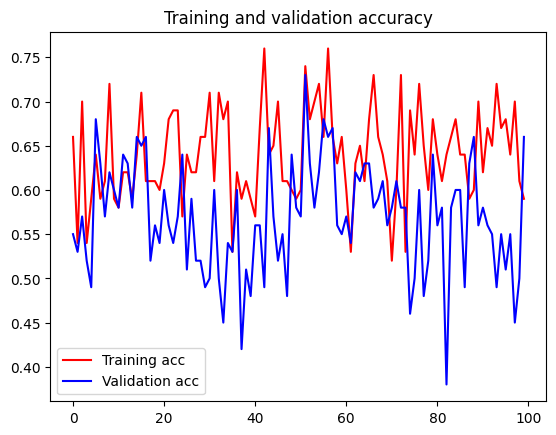

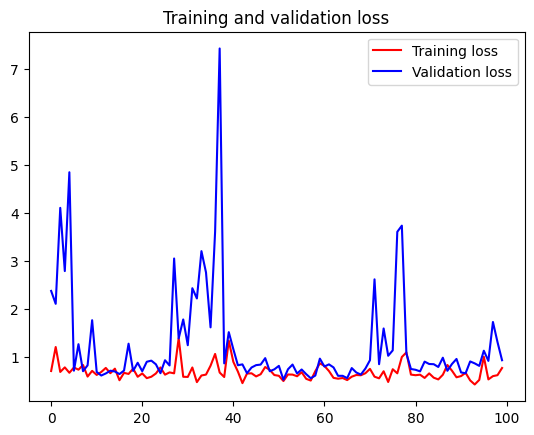

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# save model

In [21]:
os.makedirs('/content/drive/MyDrive/Model', exist_ok=True)
modeltwo.save('/content/drive/MyDrive/Model/part_id14(200).h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
